## EDA

### 1.1: Load the Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
from utils import FitData


In [1]:
import os

# URL of the dataset
url = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
zip_file = "ml-32m.zip"
extract_folder = "ml-32m"

print(f"Starting download of {url}...")

# Use !wget to download the file in Colab
# -q makes it quiet (less output)
!wget -q $url

print("Download complete.")

# Check if the file was downloaded successfully
if os.path.exists(zip_file):
    print(f"Successfully downloaded {zip_file}.")

    # Unzip the file
    print(f"Unzipping {zip_file}...")
    # -o overwrites existing files without asking
    # -d specifies the directory to extract to
    !unzip -o $zip_file -d $extract_folder

    print(f"Successfully unzipped to '{extract_folder}' folder.")

    # List the contents of the extracted folder
    print(f"\nContents of {extract_folder}:")
    !ls -l $extract_folder
else:
    print(f"Error: {zip_file} was not downloaded.")

Starting download of https://files.grouplens.org/datasets/movielens/ml-32m.zip...
Download complete.
Successfully downloaded ml-32m.zip.
Unzipping ml-32m.zip...
Archive:  ml-32m.zip
   creating: ml-32m/ml-32m/
  inflating: ml-32m/ml-32m/tags.csv  
  inflating: ml-32m/ml-32m/links.csv  
  inflating: ml-32m/ml-32m/README.txt  
  inflating: ml-32m/ml-32m/checksums.txt  
  inflating: ml-32m/ml-32m/ratings.csv  
  inflating: ml-32m/ml-32m/movies.csv  
Successfully unzipped to 'ml-32m' folder.

Contents of ml-32m:
total 9
drwxrwxr-x 2 dolan people 8 Oct 13  2023 ml-32m


In [ ]:
file_path = "ml-32m/ml-32m/ratings.csv"
data = FitData(file_path)
data.load()

### 1.3: Plottings

In [ ]:
import math
import sys
from collections import Counter

# Optional: scipy.sparse for spy visualization if installed
try:
    from scipy import sparse
    SCIPY_SPARSE_AVAILABLE = True
except Exception:
    SCIPY_SPARSE_AVAILABLE = False

# ---------------------------
# Helper: load and normalize input arrays
# ---------------------------
def _extract_arrays():
    """
    Attempts to find user/movie/score arrays in the current global namespace.
    Accepts either:
      - users, movies, scores  (each array-like)
    or
      - ratings  (list of tuples (user,movie,score) or dicts)
    Returns: users_arr, movies_arr, scores_arr, timestamps_arr_or_None
    """
    g = globals()
    # Check direct arrays first
    users = g.get('users', None)
    movies = g.get('movies', None)
    scores = g.get('scores', None)
    timestamps = g.get('timestamps', None)

    if users is not None and movies is not None and scores is not None:
        users_arr = np.asarray(users)
        movies_arr = np.asarray(movies)
        scores_arr = np.asarray(scores, dtype=float)
        if timestamps is not None:
            timestamps_arr = np.asarray(timestamps)
        else:
            timestamps_arr = None
        return users_arr, movies_arr, scores_arr, timestamps_arr

    # Otherwise try `ratings`
    ratings = g.get('ratings', None)
    if ratings is None:
        raise RuntimeError("Could not find 'users, movies, scores' or 'ratings' in globals().\n"
                           "Please provide arrays named users, movies, scores, or a list named ratings.")
    # ratings could be list of tuples (user, movie, score) or (user,movie,score,timestamp)
    # or list of dicts with keys 'userId','movieId','rating','timestamp'
    users_list, movies_list, scores_list, timestamps_list = [], [], [], []
    for r in ratings:
        if isinstance(r, dict):
            users_list.append(r.get('userId') or r.get('user') or r.get('user_id'))
            movies_list.append(r.get('movieId') or r.get('movie') or r.get('movie_id'))
            scores_list.append(r.get('rating') or r.get('score'))
            timestamps_list.append(r.get('timestamp') or r.get('time'))
        elif isinstance(r, (list, tuple)) and len(r) >= 3:
            users_list.append(r[0])
            movies_list.append(r[1])
            scores_list.append(r[2])
            if len(r) >= 4:
                timestamps_list.append(r[3])
        else:
            raise RuntimeError("Unrecognized ratings entry format. Expected tuple/list/dict.")
    users_arr = np.asarray(users_list)
    movies_arr = np.asarray(movies_list)
    scores_arr = np.asarray(scores_list, dtype=float)
    timestamps_arr = np.asarray(timestamps_list) if len(timestamps_list) > 0 else None
    return users_arr, movies_arr, scores_arr, timestamps_arr

# Pull arrays from globals
users_arr, movies_arr, scores_arr, timestamps_arr = _extract_arrays()

# Basic counts & unique mappings (we'll create compact id indices)
user_ids, user_counts = np.unique(users_arr, return_counts=True)
movie_ids, movie_counts = np.unique(movies_arr, return_counts=True)
n_users = len(user_ids)
n_movies = len(movie_ids)
n_ratings = len(scores_arr)
total_possible = n_users * n_movies
sparsity_percent = 100.0 * (1 - n_ratings / float(total_possible)) if total_possible>0 else np.nan

# Map raw ids to contiguous indices (0..N-1)
user_to_idx = {uid: i for i, uid in enumerate(user_ids)}
movie_to_idx = {mid: i for i, mid in enumerate(movie_ids)}
user_idx = np.array([user_to_idx[u] for u in users_arr], dtype=int)
movie_idx = np.array([movie_to_idx[m] for m in movies_arr], dtype=int)

# Create counters for quick queries
user_counter = Counter(user_idx)
movie_counter = Counter(movie_idx)

# Utility: safe save figure as PDF and close
def save_pdf(fig, filename):
    fig.savefig(filename, format='pdf', bbox_inches='tight')
    plt.close(fig)
    print(f"✓ Saved: {filename}")

# ---------------------------
# 1) Rating histogram + simple density (smoothed histogram)
# ---------------------------
def plot_rating_histogram(scores, filename='01_rating_histogram.pdf'):
    fig, ax = plt.subplots(figsize=(8,6))
    bins = np.arange(np.floor(scores.min()) - 0.5, np.ceil(scores.max()) + 0.5, 0.5)
    counts, edges, patches = ax.hist(scores, bins=bins, edgecolor='black', linewidth=0.6)
    ax.set_title('Rating Distribution (Histogram)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    # simple smoothing line: normalized counts via moving average on bin centers
    centers = (edges[:-1] + edges[1:]) / 2.0
    window = 3
    smooth = np.convolve(counts, np.ones(window)/window, mode='same')
    ax.plot(centers, smooth, linewidth=2.0)
    # stats box
    ax.text(0.02, 0.98, f'N={len(scores):,}\nMean={scores.mean():.3f}\nMedian={np.median(scores):.2f}\nStd={scores.std():.3f}',
            transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 2) Rating value counts (bar)
# ---------------------------
def plot_rating_value_counts(scores, filename='02_rating_value_counts.pdf'):
    unique_vals, counts = np.unique(scores, return_counts=True)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.bar(unique_vals, counts, width=0.4, edgecolor='black')
    ax.set_xticks(unique_vals)
    ax.set_title('Count by Rating Value', fontsize=14, fontweight='bold')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    # annotate values
    for x, c in zip(unique_vals, counts):
        ax.text(x, c, f'{c:,}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 3) Rating boxplot
# ---------------------------
def plot_rating_boxplot(scores, filename='03_rating_boxplot.pdf'):
    fig, ax = plt.subplots(figsize=(6,6))
    bp = ax.boxplot(scores, vert=True, widths=0.5, patch_artist=True, notch=False)
    # style manually (no seaborn)
    for box in bp['boxes']:
        box.set(facecolor='#cfe8ff', edgecolor='navy')
    for median in bp['medians']:
        median.set(color='red', linewidth=2)
    ax.set_xticks([1])
    ax.set_xticklabels(['All Ratings'])
    ax.set_ylabel('Rating')
    ax.set_title('Rating Distribution (Box Plot)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 4) User activity distribution histogram + CCDF
# ---------------------------
def plot_user_activity(user_counts_raw, filename_hist='04_user_activity_hist.pdf', filename_ccdf='05_user_activity_ccdf.pdf'):
    counts = user_counts_raw.copy()
    fig, ax = plt.subplots(figsize=(8,6))
    bins = np.logspace(0, math.ceil(math.log10(counts.max()+1)), 50)
    ax.hist(counts, bins=bins, edgecolor='black')
    ax.set_xscale('log')
    ax.set_xlabel('Number of Ratings per User (log scale)')
    ax.set_ylabel('Number of Users')
    ax.set_title('User Activity Distribution (Histogram, log x)')
    plt.tight_layout()
    save_pdf(fig, filename_hist)

    # CCDF
    sorted_counts = np.sort(counts)
    ranks = np.arange(1, len(sorted_counts)+1)
    ccdf = 1.0 - np.arange(len(sorted_counts)) / float(len(sorted_counts))
    fig, ax = plt.subplots(figsize=(8,6))
    ax.loglog(sorted_counts[::-1], ccdf, marker='.', linestyle='none')
    ax.set_xlabel('k (ratings per user)')
    ax.set_ylabel('CCDF P(X >= k)')
    ax.set_title('User Activity CCDF (log-log)')
    plt.tight_layout()
    save_pdf(fig, filename_ccdf)

# ---------------------------
# 5) Movie popularity distribution histogram + CCDF
# ---------------------------
def plot_movie_popularity(movie_counts_raw, filename_hist='06_movie_popularity_hist.pdf', filename_ccdf='07_movie_popularity_ccdf.pdf'):
    counts = movie_counts_raw.copy()
    fig, ax = plt.subplots(figsize=(8,6))
    bins = np.logspace(0, math.ceil(math.log10(counts.max()+1)), 50)
    ax.hist(counts, bins=bins, edgecolor='black')
    ax.set_xscale('log')
    ax.set_xlabel('Number of Ratings per Movie (log scale)')
    ax.set_ylabel('Number of Movies')
    ax.set_title('Movie Popularity Distribution (Histogram, log x)')
    plt.tight_layout()
    save_pdf(fig, filename_hist)

    # CCDF
    sorted_counts = np.sort(counts)
    ccdf = 1.0 - np.arange(len(sorted_counts)) / float(len(sorted_counts))
    fig, ax = plt.subplots(figsize=(8,6))
    ax.loglog(sorted_counts[::-1], ccdf, marker='.', linestyle='none')
    ax.set_xlabel('k (ratings per movie)')
    ax.set_ylabel('CCDF P(X >= k)')
    ax.set_title('Movie Popularity CCDF (log-log)')
    plt.tight_layout()
    save_pdf(fig, filename_ccdf)

# ---------------------------
# 6) Log-log rank plot (power-law style) for users and movies
# ---------------------------
def plot_rank_powerlaw(counts, label, filename):
    sorted_counts = np.sort(counts)[::-1]
    ranks = np.arange(1, len(sorted_counts)+1)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.loglog(ranks, sorted_counts, marker='.', linestyle='none')
    ax.set_xlabel(f'{label} Rank (log)')
    ax.set_ylabel('Count (log)')
    ax.set_title(f'{label} Rank-Count (log-log)')
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 7) Top-K bar plots (Top 20 movies, Top 20 users)
# ---------------------------
def plot_top_k(counter_obj, id_list, k=20, id_label='Movie', filename='top_k.pdf'):
    # counter_obj: Counter mapping index->count
    most = counter_obj.most_common(k)
    ids = [id_list[i] for i, _ in most]  # raw ids
    counts = [c for _, c in most]
    y_pos = np.arange(len(ids))
    fig, ax = plt.subplots(figsize=(9, max(4, len(ids)*0.35)))
    ax.barh(y_pos, counts, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f'{id_label} {iid}' for iid in ids])
    ax.invert_yaxis()
    ax.set_xlabel('Number of Ratings')
    ax.set_title(f'Top {k} Most Rated {id_label}s')
    # annotate counts
    for i, c in enumerate(counts):
        ax.text(c, i, f' {c:,}', va='center')
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 8) Matrix sparsity pie chart (filled vs empty)
# ---------------------------
def plot_sparsity_pie(n_users, n_movies, n_ratings, filename='sparsity_pie.pdf'):
    total = n_users * n_movies
    filled = n_ratings
    empty = total - filled
    if total == 0:
        raise RuntimeError("Zero users or movies; cannot compute sparsity pie.")
    labels = ['Filled', 'Empty']
    sizes = [filled, empty]
    fig, ax = plt.subplots(figsize=(6,6))
    ax.pie(sizes, labels=labels, autopct='%1.3f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    ax.set_title(f'Matrix Sparsity\n({n_users:,} users × {n_movies:,} movies)', fontsize=12)
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 9) Spy plot (sparsity pattern) for a sampled block
# ---------------------------
def plot_spy(user_idx_arr, movie_idx_arr, n_users, n_movies, filename='spy_plot.pdf', sample_block=500):
    """
    Creates a spy-style plot (dots where ratings exist).
    For large matrices we sample a block of size sample_block x sample_block:
      - choose most active users and most popular movies to create a representative block.
    If scipy.sparse available, uses sparse coo matrix; otherwise falls back to scatter.
    """
    # choose top users and movies by counts
    top_user_indices = np.array([u for u,_ in user_counter.most_common(sample_block)])
    top_movie_indices = np.array([m for m,_ in movie_counter.most_common(sample_block)])
    # mask to select only entries in this block
    mask = np.isin(user_idx_arr, top_user_indices) & np.isin(movie_idx_arr, top_movie_indices)
    u_sel = user_idx_arr[mask]
    m_sel = movie_idx_arr[mask]
    # remap to 0..block-1
    user_map = {old:i for i,old in enumerate(top_user_indices)}
    movie_map = {old:i for i,old in enumerate(top_movie_indices)}
    u_mapped = np.array([user_map[u] for u in u_sel])
    m_mapped = np.array([movie_map[m] for m in m_sel])
    fig, ax = plt.subplots(figsize=(8,8))
    # scatter
    ax.scatter(m_mapped, u_mapped, s=1)
    ax.set_xlim(-0.5, len(top_movie_indices)-0.5)
    ax.set_ylim(-0.5, len(top_user_indices)-0.5)
    ax.set_xlabel('Top Movies (index)')
    ax.set_ylabel('Top Users (index)')
    ax.set_title(f'Sparsity Pattern (sample block {len(top_user_indices)}×{len(top_movie_indices)})')
    ax.invert_yaxis()
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 10) Small dataset summary table as a PDF figure
# ---------------------------
def plot_dataset_table(n_ratings, n_users, n_movies, user_counts_raw, movie_counts_raw, scores, sparsity_percent, filename='dataset_summary_table.pdf'):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.axis('off')
    stats = [
        ['Total Ratings', f'{n_ratings:,}'],
        ['Unique Users', f'{n_users:,}'],
        ['Unique Movies', f'{n_movies:,}'],
        ['Avg Ratings/User', f'{np.mean(user_counts_raw):.2f}'],
        ['Avg Ratings/Movie', f'{np.mean(movie_counts_raw):.2f}'],
        ['Rating Mean', f'{np.mean(scores):.3f}'],
        ['Rating Std', f'{np.std(scores):.3f}'],
        ['Rating Median', f'{np.median(scores):.2f}'],
        ['Sparsity', f'{sparsity_percent:.6f}%'],
    ]
    table = ax.table(cellText=stats, colWidths=[0.6, 0.4], cellLoc='left', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    ax.set_title('Dataset Summary', fontsize=12, fontweight='bold', pad=10)
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 11) Time-series of ratings if timestamps available (ratings per day/month)
# ---------------------------
def plot_time_series(timestamps, filename='time_series_ratings.pdf', freq='monthly'):
    if timestamps is None:
        print("skipping time-series plot (no timestamps available)")
        return
    # Try to interpret timestamps: if numeric seconds, convert to numpy datetime64
    try:
        ts = np.asarray(timestamps)
        # if ints (unix time seconds)
        if np.issubdtype(ts.dtype, np.integer) or np.issubdtype(ts.dtype, np.floating):
            dt = ts.astype('datetime64[s]')
        else:
            # attempt to parse strings
            dt = ts.astype('datetime64[s]')
    except Exception:
        print("Could not parse timestamps -> skipping time-series plot.")
        return

    # aggregate per month
    months = np.array([d.astype('datetime64[M]') for d in dt])
    unique_months, counts = np.unique(months, return_counts=True)
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(unique_months.astype('datetime64[M]').astype('O'), counts, marker='o', linestyle='-')
    ax.set_title('Ratings over Time (per month)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Ratings Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# Run all plotting functions
# ---------------------------
if __name__ == '__main__':
    # 1
    plot_rating_histogram(scores_arr, filename='01_rating_histogram.pdf')

    # 2
    plot_rating_value_counts(scores_arr, filename='02_rating_value_counts.pdf')

    # 3
    plot_rating_boxplot(scores_arr, filename='03_rating_boxplot.pdf')

    # 4 user counts: convert unique(user_idx) counts to array aligned with user_ids
    # we already have user_counts from np.unique earlier
    plot_user_activity(user_counts, filename_hist='04_user_activity_hist.pdf', filename_ccdf='05_user_activity_ccdf.pdf')

    # 5 movie popularity
    plot_movie_popularity(movie_counts, filename_hist='06_movie_popularity_hist.pdf', filename_ccdf='07_movie_popularity_ccdf.pdf')

    # 6 log-log rank plots
    plot_rank_powerlaw(user_counts, 'User Activity', '08_user_rank_powerlaw.pdf')
    plot_rank_powerlaw(movie_counts, 'Movie Popularity', '09_movie_rank_powerlaw.pdf')

    # 7 Top 20 bar plots
    # For mapping back to original IDs for top-k, we pass lists of raw ids (user_ids/movie_ids)
    plot_top_k(user_counter, user_ids, k=20, id_label='User', filename='10_top_20_users.pdf')
    plot_top_k(movie_counter, movie_ids, k=20, id_label='Movie', filename='11_top_20_movies.pdf')

    # 8 Sparsity pie
    plot_sparsity_pie(n_users, n_movies, n_ratings, filename='12_sparsity_pie.pdf')

    # 9 Spy plot (sampled)
    plot_spy(user_idx, movie_idx, n_users, n_movies, filename='13_spy_plot.pdf', sample_block=500)

    # 10 Dataset table
    plot_dataset_table(n_ratings, n_users, n_movies, user_counts, movie_counts, scores_arr, sparsity_percent, filename='14_dataset_summary_table.pdf')

    # 11 Time series if timestamps available
    plot_time_series(timestamps_arr, filename='15_time_series_ratings.pdf')

    # Final summary print
    print("\nAll requested Option A plots saved as separate PDF files.")
    print("Files created (PDF):")
    print("  01_rating_histogram.pdf")
    print("  02_rating_value_counts.pdf")
    print("  03_rating_boxplot.pdf")
    print("  04_user_activity_hist.pdf")
    print("  05_user_activity_ccdf.pdf")
    print("  06_movie_popularity_hist.pdf")
    print("  07_movie_popularity_ccdf.pdf")
    print("  08_user_rank_powerlaw.pdf")
    print("  09_movie_rank_powerlaw.pdf")
    print("  10_top_20_users.pdf")
    print("  11_top_20_movies.pdf")
    print("  12_sparsity_pie.pdf")
    print("  13_spy_plot.pdf")
    print("  14_dataset_summary_table.pdf")
    print("  15_time_series_ratings.pdf (only if timestamps were present)")


✓ Saved: 01_rating_histogram.pdf
✓ Saved: 02_rating_value_counts.pdf
✓ Saved: 03_rating_boxplot.pdf
✓ Saved: 04_user_activity_hist.pdf
✓ Saved: 05_user_activity_ccdf.pdf
✓ Saved: 06_movie_popularity_hist.pdf
✓ Saved: 07_movie_popularity_ccdf.pdf
✓ Saved: 08_user_rank_powerlaw.pdf
✓ Saved: 09_movie_rank_powerlaw.pdf
✓ Saved: 10_top_20_users.pdf
✓ Saved: 11_top_20_movies.pdf
✓ Saved: 12_sparsity_pie.pdf
✓ Saved: 13_spy_plot.pdf
✓ Saved: 14_dataset_summary_table.pdf
skipping time-series plot (no timestamps available)

All requested Option A plots saved as separate PDF files.
Files created (PDF):
  01_rating_histogram.pdf
  02_rating_value_counts.pdf
  03_rating_boxplot.pdf
  04_user_activity_hist.pdf
  05_user_activity_ccdf.pdf
  06_movie_popularity_hist.pdf
  07_movie_popularity_ccdf.pdf
  08_user_rank_powerlaw.pdf
  09_movie_rank_powerlaw.pdf
  10_top_20_users.pdf
  11_top_20_movies.pdf
  12_sparsity_pie.pdf
  13_spy_plot.pdf
  14_dataset_summary_table.pdf
  15_time_series_ratings.pdf (

### 1.4: Power Law Plotting

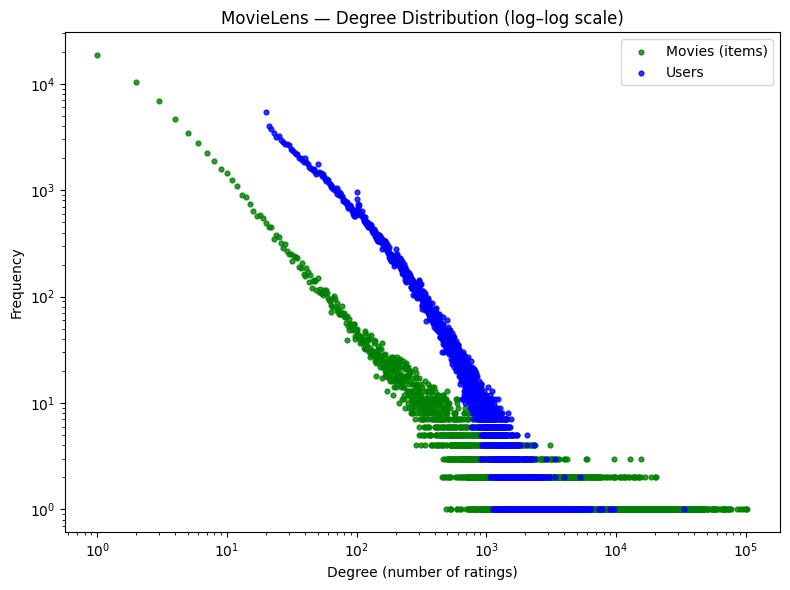

In [ ]:

fd = FitData("ml-32m/ml-32m/ratings.csv", "ml-32m/ml-32m/movies.csv")
fd.load()

# --------------------------------------------------------
# Compute degree counts from your FitData loader
# --------------------------------------------------------
movie_rating_counts = np.array([len(lst) for lst in fd.data_by_movie], dtype=np.int32)
user_rating_counts  = np.array([len(lst) for lst in fd.data_by_user], dtype=np.int32)

def degree_frequency(data):
    unique, counts = np.unique(data, return_counts=True)
    return unique, counts

movie_degree, movie_freq = degree_frequency(movie_rating_counts)
user_degree,  user_freq  = degree_frequency(user_rating_counts)

# --------------------------------------------------------
# Plot: Degree Distribution (log–log)
# --------------------------------------------------------
plt.figure(figsize=(8, 6))

plt.scatter(movie_degree, movie_freq, s=12, color='green',
            label='Movies (items)', alpha=0.8)
plt.scatter(user_degree, user_freq, s=12, color='blue',
            label='Users', alpha=0.8)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Degree (number of ratings)')
plt.ylabel('Frequency')
plt.title('MovieLens — Degree Distribution (log–log scale)')
plt.legend()

plt.tight_layout()

# --------------------------------------------------------
# SAVE AS PDF
# --------------------------------------------------------
plt.savefig("degree_distribution.pdf", format="pdf")

plt.show()


## 100k Dataset

### 2.1: Load the dataset

In [ ]:
import os
import csv
import numpy as np
import pandas as pd
from utils import FitData
import matplotlib.pyplot as plt

In [ ]:
# Download and unzip MovieLens 100K (latest small version)
!wget -q https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -O ml-latest-small.zip
!unzip -q -o ml-latest-small.zip

# Set data path and file name
data_path = "ml-latest-small/"
data_file = "ratings.csv"

# Load the CSV file into a pandas DataFrame
ratings = pd.read_csv(os.path.join(data_path, data_file))

# Display first few rows
print(ratings.head())
print("\nShape:", ratings.shape)


   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Shape: (100836, 4)


In [ ]:
file_path = os.path.join(data_path, data_file)

df = FitData(file_path)
df.load()


### 2.2: Split the dataset

In [ ]:
n_users = len(df.data_by_user)
n_movies = len(df.data_by_movie)

data_by_user_train = [[] for _ in range(n_users)]
data_by_user_test  = [[] for _ in range(n_users)]
data_by_movie_train = [[] for _ in range(n_movies)]
data_by_movie_test  = [[] for _ in range(n_movies)]

for i in range(n_users):
    ratings = df.data_by_user[i] # change variable name
    for movie_id, rating in ratings:
        if np.random.rand() < 0.9:
            data_by_user_train[i].append((movie_id, rating))
        else:
            data_by_user_test[i].append((movie_id, rating))

for i in range(n_users):
    user_id = df.idx_to_user_id[i]

    # train
    for movie_id, rating in data_by_user_train[i]:
        m_idx = df.movie_id_to_idx[movie_id]
        data_by_movie_train[m_idx].append((user_id, rating))

    # test
    for movie_id, rating in data_by_user_test[i]:
        m_idx = df.movie_id_to_idx[movie_id]
        data_by_movie_test[m_idx].append((user_id, rating))

In [ ]:
non_empty_users_train = sum(1 for u in data_by_user_train if len(u) > 0)
non_empty_users_test = sum(1 for u in data_by_user_test if len(u) > 0)

print(f"number of items in users train and test sets: {len(data_by_user_train)} , {len(data_by_user_test)}")
print(f"Number of users with ratings in train and test sets: {non_empty_users_train}, {non_empty_users_test}")

print()

non_empty_movies_train = sum(1 for u in data_by_movie_train if len(u) > 0)
non_empty_movies_test = sum(1 for u in data_by_movie_test if len(u) > 0)

print(f"number of items in movies train and test sets: {len(data_by_movie_train)}, {len(data_by_movie_test)}")
print(f"Number of movies with ratings in train and test sets: {non_empty_movies_train}, {non_empty_movies_test}")

number of items in users train and test sets: 610 , 610
Number of users with ratings in train and test sets: 610, 604

number of items in movies train and test sets: 9724, 9724
Number of movies with ratings in train and test sets: 9360, 3699


## 2.3: Bias Optimisation

Iter 1: Train RMSE=0.8044, Test RMSE=0.8805
Iter 2: Train RMSE=0.7886, Test RMSE=0.8642
Iter 3: Train RMSE=0.7873, Test RMSE=0.8632
Iter 4: Train RMSE=0.7871, Test RMSE=0.8631
Iter 5: Train RMSE=0.7871, Test RMSE=0.8631
Iter 6: Train RMSE=0.7870, Test RMSE=0.8631
Iter 7: Train RMSE=0.7870, Test RMSE=0.8631
Iter 8: Train RMSE=0.7870, Test RMSE=0.8631
Iter 9: Train RMSE=0.7870, Test RMSE=0.8631
Iter 10: Train RMSE=0.7870, Test RMSE=0.8631


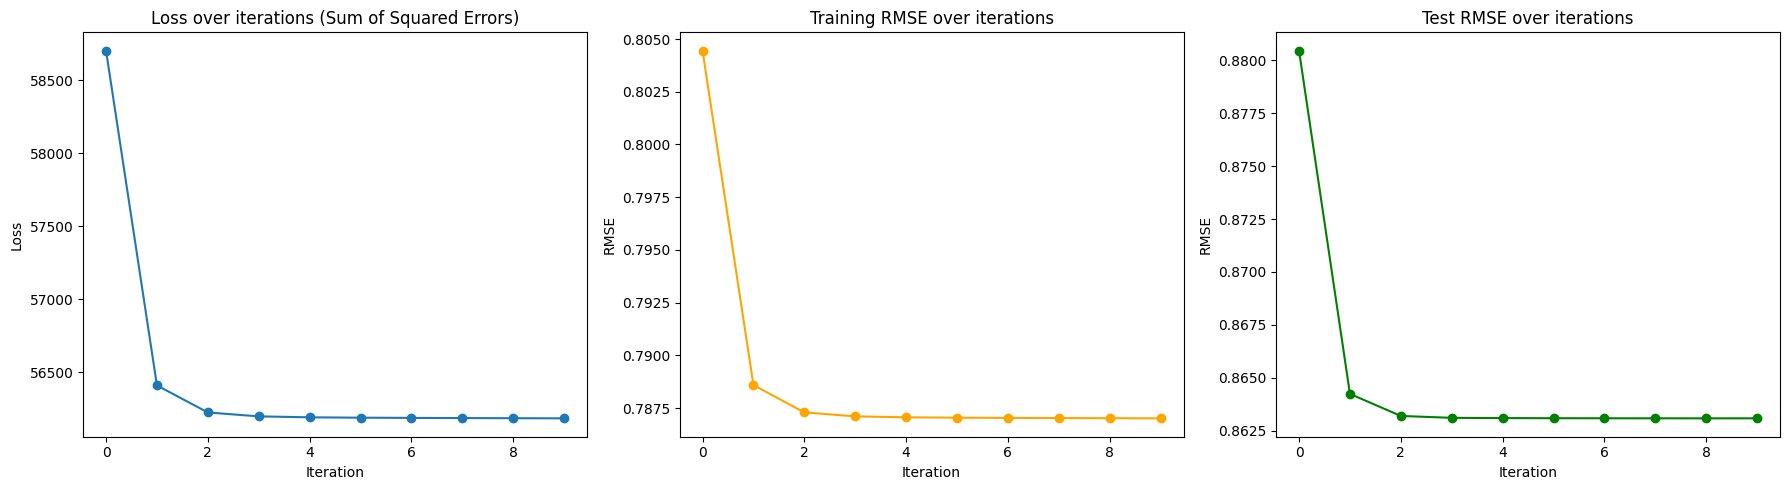

In [ ]:
M = n_users
N = n_movies

lambd = 0.5   # regularization weight
gamma = 1e-8  # small smoothing term
num_iters = 10

user_biases = np.zeros(M)
item_biases = np.zeros(N)

# Compute global mean rating
mu = np.mean([r for user_ratings in data_by_user_train for (_, r) in user_ratings])

loss_history, rmse_history, rmse_test_history = [], [], []

for it in range(num_iters):
    # --- Update user biases ---
    for m in range(M):
        num = 0.0
        cnt = 0
        for (movie_id, r) in data_by_user_train[m]:
            n = df.movie_id_to_idx[movie_id]
            num += (r - mu - item_biases[n])
            cnt += 1
        if cnt > 0:
            user_biases[m] = num / (lambd + cnt + gamma)

    # --- Update item biases ---
    for n in range(N):
        num = 0.0
        cnt = 0
        for (user_id, r) in data_by_movie_train[n]:
            m_idx = df.user_id_to_idx[user_id]
            num += (r - mu - user_biases[m_idx])
            cnt += 1
        if cnt > 0:
            item_biases[n] = num / (lambd + cnt + gamma)

    # --- Compute training metrics ---
    sq_err = 0.0
    count = 0
    for m in range(M):
        for movie_id, r in data_by_user_train[m]:
            n = df.movie_id_to_idx[movie_id]
            pred = mu + user_biases[m] + item_biases[n]
            sq_err += (r - pred) ** 2
            count += 1
    rmse_train = np.sqrt(sq_err / count)
    rmse_history.append(rmse_train)
    loss_history.append(sq_err)

    # --- Compute test RMSE ---
    sq_err_test = 0.0
    count_test = 0
    for m in range(M):
        for movie_id, r in data_by_user_test[m]:
            n = df.movie_id_to_idx[movie_id]
            pred = mu + user_biases[m] + item_biases[n]
            sq_err_test += (r - pred) ** 2
            count_test += 1
    rmse_test = np.sqrt(sq_err_test / count_test)
    rmse_test_history.append(rmse_test)

    print(f"Iter {it+1}: Train RMSE={rmse_train:.4f}, Test RMSE={rmse_test:.4f}")

# --- Plot ---
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(loss_history, marker='o')
plt.title("Loss over iterations (Sum of Squared Errors)")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1,3,2)
plt.plot(rmse_history, marker='o', color='orange')
plt.title("Training RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.subplot(1,3,3)
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()


## 32m Dataset training  (practical 3 and practical 4)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import FitData
import os
import math

In [ ]:


class ALS:
    def __init__(self, df, data_by_user_train, data_by_user_test,
                 data_by_movie_train, data_by_movie_test, K=25, lambd=0.01, num_iters=10):
        self.df = df
        self.data_by_user_train = data_by_user_train
        self.data_by_user_test = data_by_user_test
        self.data_by_movie_train = data_by_movie_train
        self.data_by_movie_test = data_by_movie_test

        self.M = len(df.data_by_user)
        self.N = len(df.data_by_movie)
        self.K = K
        self.lambd = lambd
        self.num_iters = num_iters

        # Initialize parameters
        self.user_biases = np.zeros(self.M)
        self.item_biases = np.zeros(self.N)
        self.U = 0.1 * np.random.randn(self.M, K)
        self.V = 0.1 * np.random.randn(self.N, K)
        self.mu = np.mean([r for ratings in self.data_by_user_train for (_,r) in ratings])

        # Tracking history
        self.loss_hist = []
        self.rmse_hist = []
        self.rmse_test_hist = []

    def train(self):
        for it in range(self.num_iters):
            self.update_user_biases()
            self.update_item_biases()
            self.update_user_latent()
            self.update_item_latent()
            self.compute_metrics(it)

    def update_user_biases(self):
        for m in range(self.M):
            num = 0.0
            den = self.lambd
            for (movie_id, r) in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                num += (r - self.mu - self.item_biases[n] - self.U[m] @ self.V[n])
                den += 1
            self.user_biases[m] = num / den

    def update_item_biases(self):
        for n in range(self.N):
            num = 0.0
            den = self.lambd
            for (user_id, r) in self.data_by_movie_train[n]:
                m = self.df.user_id_to_idx[user_id]
                num += (r - self.mu - self.user_biases[m] - self.U[m] @ self.V[n])
                den += 1
            self.item_biases[n] = num / den

    def update_user_latent(self):
        for m in range(self.M):
            A = self.lambd * np.eye(self.K)
            b = np.zeros(self.K)
            for (movie_id, r) in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                v = self.V[n]
                A += np.outer(v, v)
                b += v * (r - self.mu - self.user_biases[m] - self.item_biases[n])
            self.U[m] = np.linalg.solve(A, b)

    def update_item_latent(self):
        for n in range(self.N):
            A = self.lambd * np.eye(self.K)
            b = np.zeros(self.K)
            for (user_id, r) in self.data_by_movie_train[n]:
                m = self.df.user_id_to_idx[user_id]
                u = self.U[m]
                A += np.outer(u, u)
                b += u * (r - self.mu - self.user_biases[m] - self.item_biases[n])
            self.V[n] = np.linalg.solve(A, b)

    def compute_metrics(self, iteration):
        # Train RMSE
        sq_err = 0
        cnt = 0
        for m in range(self.M):
            for (movie_id, r) in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                pred = self.mu + self.user_biases[m] + self.item_biases[n] + self.U[m] @ self.V[n]
                sq_err += (r - pred)**2
                cnt += 1
        rmse_train = np.sqrt(sq_err / cnt)
        self.rmse_hist.append(rmse_train)
        self.loss_hist.append(sq_err)

        # Test RMSE
        sq_err_test = 0
        cnt_test = 0
        for m in range(self.M):
            for (movie_id, r) in self.data_by_user_test[m]:
                n = self.df.movie_id_to_idx[movie_id]
                pred = self.mu + self.user_biases[m] + self.item_biases[n] + self.U[m] @ self.V[n]
                sq_err_test += (r - pred)**2
                cnt_test += 1
        rmse_test = np.sqrt(sq_err_test / cnt_test)
        self.rmse_test_hist.append(rmse_test)

        print(f"Iter {iteration+1}: Train RMSE={rmse_train:.4f}, Test RMSE={rmse_test:.4f}")

    def plot_metrics(self):
        plt.figure(figsize=(15,4))

        plt.subplot(1,3,1)
        plt.plot(self.loss_hist, marker='o')
        plt.title("Loss (SSE)")
        plt.xlabel("Iteration")

        plt.subplot(1,3,2)
        plt.plot(self.rmse_hist, marker='o')
        plt.title("Train RMSE")

        plt.subplot(1,3,3)
        plt.plot(self.rmse_test_hist, marker='o')
        plt.title("Test RMSE")

        plt.tight_layout()
        plt.show()



Iter 1: Train RMSE=0.4699, Test RMSE=2.1848
Iter 2: Train RMSE=0.4249, Test RMSE=2.0473
Iter 3: Train RMSE=0.4005, Test RMSE=1.9697
Iter 4: Train RMSE=0.3844, Test RMSE=1.9273
Iter 5: Train RMSE=0.3726, Test RMSE=1.9065
Iter 6: Train RMSE=0.3632, Test RMSE=1.8931
Iter 7: Train RMSE=0.3555, Test RMSE=1.8823
Iter 8: Train RMSE=0.3490, Test RMSE=1.8734
Iter 9: Train RMSE=0.3435, Test RMSE=1.8634
Iter 10: Train RMSE=0.3387, Test RMSE=1.8531


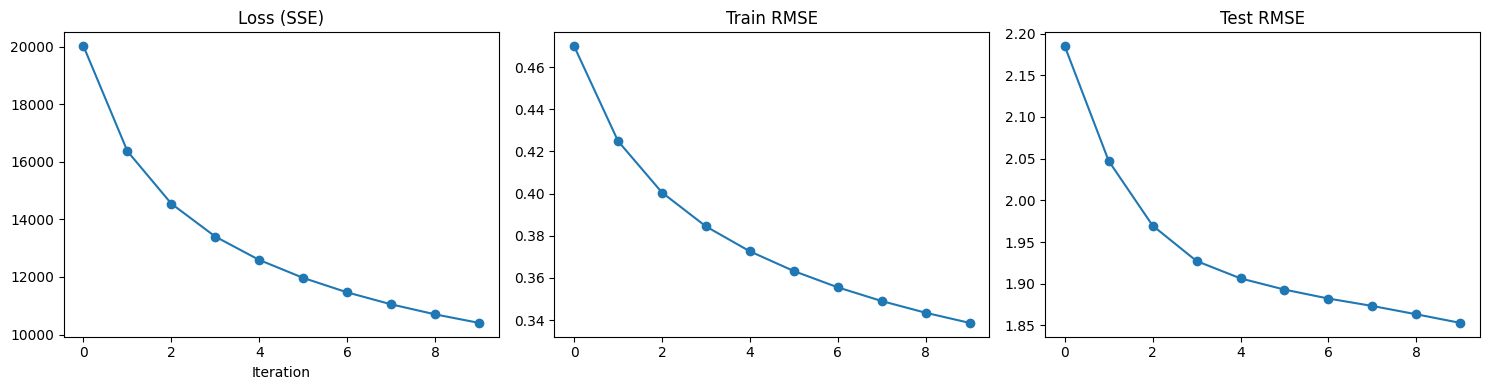

In [ ]:
# Initialize ALS
als_model = ALS(df, data_by_user_train, data_by_user_test,
                data_by_movie_train, data_by_movie_test,
                K=20, lambd=0.01, num_iters=10)

# Train the model
als_model.train()

# Plot metrics
als_model.plot_metrics()


In [ ]:
class ALSRecommender:
    def __init__(self, ratings_df, K=20, lambd=0.1, num_iters=6, test_ratio=0.2):
        self.df = ratings_df
        self.K = K
        self.lambd = lambd
        self.num_iters = num_iters
        self.test_ratio = test_ratio

        self.M = self.df.num_users()
        self.N = self.df.num_movies()

        # Train/test split containers (populated by train_test_split)
        self.data_by_user_train = []
        self.data_by_user_test = []
        self.data_by_movie_train = [[] for _ in range(self.N)]
        self.data_by_movie_test  = [[] for _ in range(self.N)]

        # ALS parameters (initialized small)
        self.U = np.random.randn(self.M, K) * 0.1
        self.V = np.random.randn(self.N, K) * 0.1
        self.user_biases = np.zeros(self.M)
        self.item_biases = np.zeros(self.N)
        self.mu = 0.0

        # History
        self.rmse_hist = []
        self.rmse_test_hist = []

        print(f"[INIT] ALS Recommender initialized with {self.M} users, {self.N} movies, K={K}, lambda={lambd}")

    def train_test_split(self):
        print("[INFO] Performing train/test split...")
        self.data_by_user_train = []
        self.data_by_user_test = []
        self.data_by_movie_train = [[] for _ in range(self.N)]
        self.data_by_movie_test  = [[] for _ in range(self.N)]

        for u_idx, ratings in enumerate(self.df.data_by_user):
            n_ratings = len(ratings)
            if n_ratings == 0:
                self.data_by_user_train.append([])
                self.data_by_user_test.append([])
                continue
            split_idx = int(math.ceil((1 - self.test_ratio) * n_ratings))
            train_ratings = ratings[:split_idx]
            test_ratings = ratings[split_idx:]

            self.data_by_user_train.append(train_ratings)
            self.data_by_user_test.append(test_ratings)

            for movie_id, r in train_ratings:
                m_idx = self.df.movie_id_to_idx[movie_id]
                self.data_by_movie_train[m_idx].append((self.df.idx_to_user_id[u_idx], r))
            for movie_id, r in test_ratings:
                m_idx = self.df.movie_id_to_idx[movie_id]
                self.data_by_movie_test[m_idx].append((self.df.idx_to_user_id[u_idx], r))

        # global mean from train only
        self.mu = np.mean([r for ratings in self.data_by_user_train for (_, r) in ratings]) if any(self.data_by_user_train) else 0.0
        print(f"[INFO] Train/test split completed. Global mean rating: {self.mu:.4f}")

    def fit(self):
        print("[INFO] Starting ALS training...")
        for it in range(self.num_iters):
            print(f"[ITER] Starting iteration {it+1}/{self.num_iters}")
            self._update_user_biases()
            self._update_item_biases()
            self._update_user_latent()
            self._update_item_latent()
            rmse_train, rmse_test = self.compute_rmse()
            self.rmse_hist.append(rmse_train)
            self.rmse_test_hist.append(rmse_test)
            print(f"[ITER {it+1}] Train RMSE={rmse_train:.4f}, Test RMSE={rmse_test:.4f}")
        print("[INFO] ALS training completed.")

    def _update_user_biases(self):
        for m in range(self.M):
            num = 0.0
            den = self.lambd
            for movie_id, r in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                num += (r - self.mu - self.item_biases[n] - self.U[m] @ self.V[n])
                den += 1
            self.user_biases[m] = num / den if den != 0 else 0.0
        print(f"[INFO] User biases updated.")

    def _update_item_biases(self):
        for n in range(self.N):
            num = 0.0
            den = self.lambd
            for user_id, r in self.data_by_movie_train[n]:
                m = self.df.user_id_to_idx[user_id]
                num += (r - self.mu - self.user_biases[m] - self.U[m] @ self.V[n])
                den += 1
            self.item_biases[n] = num / den if den != 0 else 0.0
        print(f"[INFO] Item biases updated.")

    def _update_user_latent(self):
        for m in range(self.M):
            A = self.lambd * np.eye(self.K)
            b = np.zeros(self.K)
            for movie_id, r in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                v = self.V[n]
                A += np.outer(v, v)
                b += v * (r - self.mu - self.user_biases[m] - self.item_biases[n])
            # Solve A x = b (regularized)
            self.U[m] = np.linalg.solve(A, b)
        print(f"[INFO] User latent factors updated.")

    def _update_item_latent(self):
        for n in range(self.N):
            A = self.lambd * np.eye(self.K)
            b = np.zeros(self.K)
            for user_id, r in self.data_by_movie_train[n]:
                m = self.df.user_id_to_idx[user_id]
                u = self.U[m]
                A += np.outer(u, u)
                b += u * (r - self.mu - self.user_biases[m] - self.item_biases[n])
            self.V[n] = np.linalg.solve(A, b)
        print(f"[INFO] Item latent factors updated.")

    def compute_rmse(self):
        # Train RMSE
        sq_err = 0.0
        cnt = 0
        for m in range(self.M):
            for movie_id, r in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                pred = self.mu + self.user_biases[m] + self.item_biases[n] + self.U[m] @ self.V[n]
                sq_err += (r - pred) ** 2
                cnt += 1
        rmse_train = math.sqrt(sq_err / cnt) if cnt > 0 else float('nan')

        # Test RMSE
        sq_err_test = 0.0
        cnt_test = 0
        for m in range(self.M):
            for movie_id, r in self.data_by_user_test[m]:
                n = self.df.movie_id_to_idx[movie_id]
                pred = self.mu + self.user_biases[m] + self.item_biases[n] + self.U[m] @ self.V[n]
                sq_err_test += (r - pred) ** 2
                cnt_test += 1
        rmse_test = math.sqrt(sq_err_test / cnt_test) if cnt_test > 0 else float('nan')

        print(f"[INFO] RMSE computed. Train: {rmse_train:.4f}, Test: {rmse_test:.4f}")
        return rmse_train, rmse_test

    def plot_rmse(self):
        # Train RMSE
        plt.figure(figsize=(10,5))
        plt.plot(self.rmse_hist, marker='o', color='blue')
        plt.xlabel("Iteration")
        plt.ylabel("Train RMSE")
        plt.title("ALS Train RMSE")
        plt.grid(True)
        plt.show()

        # Test RMSE
        plt.figure(figsize=(10,5))
        plt.plot(self.rmse_test_hist, marker='x', color='red')
        plt.xlabel("Iteration")
        plt.ylabel("Test RMSE")
        plt.title("ALS Test RMSE")
        plt.grid(True)
        plt.show()

    def polarizing_movies(self, top_n=10):
        norms = np.linalg.norm(self.V, axis=1)
        top_idx = np.argsort(norms)[::-1][:top_n]
        print(f"[INFO] Found top {top_n} polarizing movies.")
        return [(self.df.idx_to_movie_id[i], norms[i]) for i in top_idx]

    def infer_user_vector(self, user_ratings):
        """
        Compute latent vector for a new user based only on the ratings they provided.
        Follows the ALS user-update linear system:
            (lambda*I + sum_n v_n v_n^T) u = sum_n v_n * (r_n - mu - item_bias_n)
        Returns the solved u (K-dim numpy array).
        """
        A = self.lambd * np.eye(self.K)
        b = np.zeros(self.K)

        for movie_id, r in user_ratings:
            # skip if movie unknown in training mapping
            if movie_id not in self.df.movie_id_to_idx:
                continue
            n = self.df.movie_id_to_idx[movie_id]
            v = self.V[n]
            bias_term = self.mu + self.item_biases[n]
            A += np.outer(v, v)
            b += v * (r - bias_term)

        # solve for u
        return np.linalg.solve(A, b)

    def recommend_for_user(self, user_id, top_n=10, min_ratings=100):
        """
        If user exists in training mapping, use learned U[u_idx].
        If user is NEW, look at last entry in self.df.data_by_user (expected to be the new user's ratings)
        and infer their latent vector from those ratings using current V and item biases.
        Returns list of movieIds (top_n).
        """
        print(f"[INFO] Generating recommendations for user {user_id}...")

        # determine user vector and rated-set
        if user_id in self.df.user_id_to_idx:
            u_idx = self.df.user_id_to_idx[user_id]
            u_vec = self.U[u_idx]
            rated_set = {movie_id for movie_id, _ in self.df.data_by_user[u_idx]}
        else:
            # Expect the last appended user in df.data_by_user to be the new user's ratings
            if len(self.df.data_by_user) == 0:
                raise ValueError("No user ratings available to infer vector for new user.")
            new_user_ratings = self.df.data_by_user[-1]
            print("[INFO] New user detected — inferring latent vector from provided ratings.")
            u_vec = self.infer_user_vector(new_user_ratings)
            rated_set = {movie_id for movie_id, _ in new_user_ratings}

        # compute lecturer-style score_for_item[n] = u_vec @ v_n + 0.05 * item_bias[n]
        score_for_item = np.zeros(self.N, dtype=np.float64)
        for n in range(self.N):
            score_for_item[n] = u_vec @ self.V[n] + 0.05 * self.item_biases[n]

        # filter by popularity (min_ratings)
        counts = [len(self.df.data_by_movie[i]) for i in range(self.N)]
        for n in range(self.N):
            if counts[n] < min_ratings:
                score_for_item[n] = -np.inf

        # exclude already rated movies
        for n in range(self.N):
            movie_id = self.df.idx_to_movie_id[n]
            if movie_id in rated_set:
                score_for_item[n] = -np.inf

        top_idx = np.argsort(score_for_item)[::-1][:top_n]
        top_movies = [self.df.idx_to_movie_id[i] for i in top_idx if score_for_item[i] != -np.inf]

        print(f"[INFO] Returning top {len(top_movies)} recommendations for user {user_id}.")
        return top_movies


In [ ]:
DATA_ZIP = "ml-32m.zip"
DATA_DIR = "ml-32m"
RATINGS_CSV = os.path.join(DATA_DIR, "ratings.csv")
MOVIES_CSV = os.path.join(DATA_DIR, "movies.csv")

# -----------------------
# Download MovieLens 32M if not exists
# -----------------------
if not os.path.exists(RATINGS_CSV):
    print("[INFO] Ratings CSV not found. Starting download of MovieLens 32M (~250MB)...")
    ret = os.system(f"wget -q https://files.grouplens.org/datasets/movielens/ml-32m.zip -O {DATA_ZIP}")
    if ret != 0:
        raise RuntimeError("Download failed! Check your internet connection or wget installation.")
    print("[INFO] Download complete. Unzipping the dataset...")
    ret = os.system(f"unzip -q -o {DATA_ZIP}")
    if ret != 0:
        raise RuntimeError("Unzip failed! Check if 'unzip' is installed.")
    print("[INFO] Dataset unzipped successfully.")

# -----------------------
# Load 32M ratings with logging
# -----------------------
print("[INFO] Loading ratings data from CSV...")
df = FitData(RATINGS_CSV, MOVIES_CSV)
df.load()
print(f"Users: {df.num_users()}, Movies: {df.num_movies()}")



[INFO] Loading ratings data from CSV...
Users: 200948, Movies: 84432


In [ ]:
# -----------------------
# Initialize ALS Recommender
# -----------------------
print("[INFO] Initializing ALS Recommender...")
als = ALSRecommender(df, K=20, lambd=0.05, num_iters=10)
print(f"[INFO] ALS Recommender initialized with K={als.K}, lambda={als.lambd}, num_iters={als.num_iters}")

# -----------------------
# Train/test split
# -----------------------
als.train_test_split()
print("[INFO] Train/test split completed")

total_train_ratings = sum(len(r) for r in als.data_by_user_train)
total_test_ratings = sum(len(r) for r in als.data_by_user_test)
print(f"[INFO] Total train ratings: {total_train_ratings}, Total test ratings: {total_test_ratings}")


# -----------------------
# Fit model
# -----------------------
print("[INFO] Starting ALS training...")
als.fit()
print("[INFO] ALS training completed")


# -----------------------
# Plot RMSE curves
# -----------------------
print("[INFO] Plotting RMSE curves...")
als.plot_rmse()
print("[INFO] RMSE curves plotted")




[INFO] Initializing ALS Recommender...
[INIT] ALS Recommender initialized with 200948 users, 84432 movies, K=20, lambda=0.05
[INFO] ALS Recommender initialized with K=20, lambda=0.05, num_iters=10
[INFO] Performing train/test split...
[INFO] Train/test split completed. Global mean rating: 3.5442
[INFO] Train/test split completed
[INFO] Total train ratings: 25677530, Total test ratings: 6322674
[INFO] Starting ALS training...
[INFO] Starting ALS training...
[ITER] Starting iteration 1/10
[INFO] User biases updated.
[INFO] Item biases updated.
[INFO] User latent factors updated.
[INFO] Item latent factors updated.
[INFO] RMSE computed. Train: 0.7711, Test: 1.0703
[ITER 1] Train RMSE=0.7711, Test RMSE=1.0703
[ITER] Starting iteration 2/10
[INFO] User biases updated.
[INFO] Item biases updated.
[INFO] User latent factors updated.
[INFO] Item latent factors updated.
[INFO] RMSE computed. Train: 0.7197, Test: 1.0473
[ITER 2] Train RMSE=0.7197, Test RMSE=1.0473
[ITER] Starting iteration 3/10


In [8]:
# -----------------------
# Helper: Convert movie IDs → titles
# -----------------------
def movie_titles(movie_ids, df):
    result = []
    for mid in movie_ids:
        title = df.movie_id_to_title.get(mid, str(mid))
        result.append(title)
    return result

print("[INFO] Creating dummy user and rating movies...")

# Create new user ID
dummy_user_id = df.num_users() + 1

# -----------------------
# Dummy user rating a LOTR movie
# -----------------------
dummy_ratings = [
    (4993, 5.0),   # Lord of the Rings: The Fellowship of the Ring
]

# Add user latent vector + bias
als.U = np.vstack([als.U, np.random.randn(1, als.K) * 0.1])
als.user_biases = np.append(als.user_biases, 0)

# Register user in dataset
df.user_id_to_idx[dummy_user_id] = len(df.idx_to_user_id)
df.idx_to_user_id.append(dummy_user_id)
df.data_by_user.append(dummy_ratings)

# Add rating into movie → user list
for movie_id, rating in dummy_ratings:
    df.data_by_movie[df.movie_id_to_idx[movie_id]].append((dummy_user_id, rating))

# -----------------------
# Show what user rated
# -----------------------
rated_movie_ids = [mid for mid, _ in dummy_ratings]
rated_titles = movie_titles(rated_movie_ids, df)

print("[INFO] Dummy user rated the following movies:")
for title, (_, rating) in zip(rated_titles, dummy_ratings):
    print(f"- {title} with {rating} stars")

# -----------------------
# Generate recommendations
# -----------------------
top_movies = als.recommend_for_user(dummy_user_id, top_n=10)
print("[INFO] Top recommendations for dummy user:")

top_titles = movie_titles(top_movies, df)
for title in top_titles:
    print(f"- {title}")

# -----------------------
# Polarizing movies (unchanged)
# -----------------------
print("[INFO] Finding top polarizing movies...")
polarizing = als.polarizing_movies(top_n=10)

print("[INFO] Top polarizing movies (title, norm):")
for mid, norm in polarizing:
    title = df.movie_id_to_title.get(mid, str(mid))
    print(f"- {title}: {norm:.4f}")


[INFO] Creating dummy user and rating movies...
[INFO] Dummy user rated the following movies:
- Lord of the Rings: The Fellowship of the Ring, The (2001) with 5.0 stars
[INFO] Generating recommendations for user 162543...
[INFO] Returning top 10 recommendations for user 162543.
[INFO] Top recommendations for dummy user:
- 12 Chairs (1976)
- Gidget (1959)
- Copenhagen (2014)
- Maggie (2015)
- 20,000 Days on Earth (2014)
- Survivor (2015)
- Unfaithfully Yours (1948)
- Halloweentown II: Kalabar's Revenge (2001)
- Dance of the Dead (2008)
- Bob & Carol & Ted & Alice (1969)
[INFO] Finding top polarizing movies...
[INFO] Found top 10 polarizing movies.
[INFO] Top polarizing movies (title, norm):
- Samurai Cop (1989): 7.6644
- Legend of Boggy Creek, The (1972): 7.3179
- 11-11-11 (11-11-11: The Prophecy) (2011): 7.3139
- DysFunktional Family (2003): 7.1664
- Outer Space (2000): 7.0212
- Outrageous Class (Hababam sinifi) (1975): 6.9089
- Slipstream (2007): 6.8322
- Scarlet Diva (2000): 6.7737
-